In [42]:
# import pandas as pd
# from datetime import datetime, timedelta
# # خواندن فایل CSV
# df = pd.read_csv("power_code.csv")
# # تبدیل تاریخ با فرمت‌های مختلف
# df['DATE_MILADI'] = pd.to_datetime(df['DATE_MILADI'], format='mixed', errors='coerce')

# # حذف ردیف‌هایی که تبدیل تاریخ در آن‌ها ناموفق بوده
# df = df.dropna(subset=['DATE_MILADI'])
# # ساخت ستون جدید DATE با ساعت اصلاح‌شده از ستون HOUR
# df['DATE'] = df.apply(lambda row: row['DATE_MILADI'].replace(hour=int(row['HOUR']) % 24), axis=1)

# # نمایش چند سطر اول برای بررسی
# print(df[['DATE_MILADI', 'HOUR', 'DATE']].head())

# # ذخیره فایل جدید در صورت نیاز
# df.to_csv('updated_file.csv', index=False)

In [43]:
import pandas as pd
from datetime import datetime, timedelta
from darts import TimeSeries
import pandas as pd
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv("../BackUp/updated_file.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='mixed', errors='coerce')
df = df.dropna(subset=['DATE'])

In [45]:
target_date = pd.to_datetime('6/28/2025 1:00:00 AM')
df_filtered = df[(df['UNIT_NO'] == 3) & (df['DATE'] >= target_date)]
print(df_filtered.head())


          ID_NO  HOUR DATE_MILADI DATE_SHAMSI  POWER CODE  UNIT_NO  ID_EBRAZ  \
966238  1490077     1  2025-06-28    1404/4/7    116   SO        3   1427882   
966239  1490078     2  2025-06-28    1404/4/7    116   SO        3   1427883   
966240  1490079     3  2025-06-28    1404/4/7    117   SO        3   1427884   
966241  1490080     4  2025-06-28    1404/4/7    107   SO        3   1427885   
966242  1490081     5  2025-06-28    1404/4/7    107   SO        3   1427886   

       CODE3  MVAR  DAMA  ROTOOBAT   TOTAL                DATE  
966238     A  23.0  26.0      13.0  1050.0 2025-06-28 01:00:00  
966239     A  21.0  25.0      15.0  1052.0 2025-06-28 02:00:00  
966240     A  20.0  23.0      17.0  1059.0 2025-06-28 03:00:00  
966241     A  19.0  24.0      18.0   992.0 2025-06-28 04:00:00  
966242     A  16.0  24.0      18.0   996.0 2025-06-28 05:00:00  


In [46]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [47]:
duplicates = df_filtered['DATE'].duplicated().sum()
print(f"duplicates rows: {duplicates}")


duplicates rows: 0


In [48]:
df_filtered = df_filtered.drop_duplicates(subset='DATE')
df_filtered = df_filtered.groupby('DATE', as_index=False).agg({'POWER': 'mean'})

In [49]:
series = TimeSeries.from_dataframe(
    df_filtered,
    time_col='DATE',
    value_cols='POWER',
    freq='h'  
)

In [50]:
scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
series_scaled = scaler.fit_transform(series)

In [51]:
train_ratio = 0.95
train, test = series_scaled.split_after(train_ratio)

print(f"train data: {len(train)} hour")
print(f"test data: {len(test)} hour")


train data: 272 hour
test data: 15 hour


In [52]:
model = RNNModel(
    model='LSTM', 
    hidden_dim=100,
    n_rnn_layers=6,   
    dropout=0.2, 
    input_chunk_length=24, 
    output_chunk_length=12, 
    training_length=36, 
    n_epochs=100,
    random_state=42 
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [53]:
model.fit(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 445 K  | train
6 | V               | Linear           | 101    | train
-------------------------------------------------------------
445 K     Trainable params
0         Non-trainable params
445 K     Total params
1.781     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=100, n_rnn_layers=6, dropout=0.2, training_length=36, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=42)

In [54]:
pred = model.predict(n=len(test), series=train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [55]:
pred = scaler.inverse_transform(pred)
test = scaler.inverse_transform(test)

In [56]:
rmse_score = rmse(test, pred)
mae_score = mae(test, pred)
print(f"RMSE: {rmse_score:.2f}")
print(f"MAE: {mae_score:.2f}")

RMSE: 1.45
MAE: 1.17


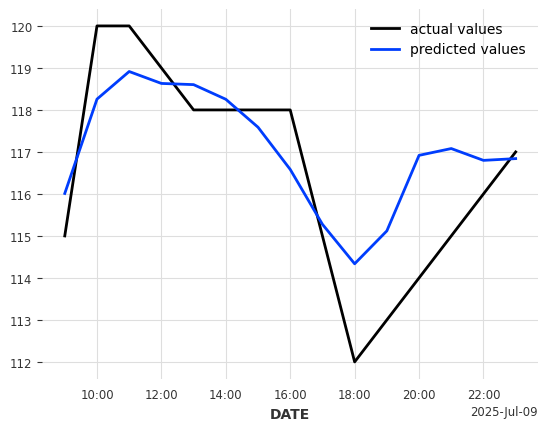

In [57]:
test.plot(label='actual values')
pred.plot(label='predicted values')
plt.legend()
plt.show()